<a href="https://colab.research.google.com/github/ishaan27chaturvedi/Conversational-Dialogue-System/blob/main/Dialogue_Act_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/MyDrive/Colab Notebooks/NN NLP ass2/lab11/")

Mounted at /content/drive


# Lab 11: Dialogue Act Tagging

Dialogue act (DA) tagging is an essential step in the development of dialog systems. DA tagging is a problem that is usually solved using supervised machine learning techniques, which all require a large amount of manually labeled data. For DA tagging, a variety of methods have been investigated. In this lab, we'll look at two different DA classification models. The Switchboard Dialog Act Corpus is being used for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [ ]:
import pandas as pd
import glob
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [ ]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [ ]:
print("Number of converations in the dataset:",len(result))

Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [ ]:
reduced_df = result[['act_tag','text']]

Reduce the number of tags to 43 by combining them and converting them to generic tags.

In [ ]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [ ]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


This dataset contains 43 tags. Yes-No-Question ('qy'), Statement-non-opinion ('sd'), and Statement-opinion ('sv') are some of the tags. Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


You can check the frequency of tags.

To get unique tags:

In [ ]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [ ]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))

In [ ]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [ ]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [ ]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [ ]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


The dataset is divided into two sections: test and training.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding),shuffle=False, stratify=None)

Pad each utterance to make them all the same length.




In [ ]:
MAX_LENGTH = 150

In [ ]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [ ]:
# Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


In [ ]:
train_input[11050]


array([ 19,  48,  17, 390,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
sentence_embeddings[11050]

[19, 48, 17, 390]

# Model 1 - 

This first model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer
- Softmax Activation

The model architecture is as follows: Embedding Layer (to generate word 
embeddings). Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get probabilities.


In [ ]:
VOCAB_SIZE = len(wordvectors)+1 
EMBED_SIZE = 100 
HIDDEN_SIZE = len(unique_tags) 

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, Activation, Embedding
from tensorflow.keras.optimizers import Adam

model = Sequential([
     Embedding(mask_zero = False, input_dim = VOCAB_SIZE+1, output_dim=EMBED_SIZE, input_length=MAX_LENGTH),
     Bidirectional(LSTM(43, return_sequences=True)),
     Bidirectional(LSTM(43, return_sequences=False)),
     Dense(HIDDEN_SIZE),
     Activation('softmax')
    ])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 100)          4373300   
                                                                 
 bidirectional_6 (Bidirectio  (None, 150, 86)          49536     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 43)                3741      
                                                                 
 activation_2 (Activation)   (None, 43)                0         
                                                                 
Total params: 4,471,297
Trainable params: 4,471,297
No

In [ ]:
# Train the model - use validation 
history = model.fit(train_input,
                    train_labels,
                    epochs=3,
                    batch_size=256,
                    validation_data=(val_input, val_labels),
                    verbose=1)

Epoch 1/3
547/547 [==============================] - 29s 44ms/step - loss: 1.5007 - accuracy: 0.5818 - val_loss: 1.1261 - val_accuracy: 0.6736
Epoch 2/3
547/547 [==============================] - 23s 42ms/step - loss: 1.0337 - accuracy: 0.6975 - val_loss: 1.0154 - val_accuracy: 0.6964
Epoch 3/3
547/547 [==============================] - 27s 49ms/step - loss: 0.8932 - accuracy: 0.7366 - val_loss: 1.0016 - val_accuracy: 0.6908


In [ ]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 10s 18ms/step - loss: 0.9978 - accuracy: 0.6876


In [ ]:
print("Overall Accuracy:", score[1]*100)


Overall Accuracy: 68.76497864723206


## Evaluation




You should look at the accuracy of some minority classes in addition to overall accuracy. Signal-non-understanding ('br') is a good indicator of "other-repair," or situations in which the other conversational participant tries to correct the speaker's mistake. In dialogue summarization, the term "summarize/reformulate" ('bf') has been used. Report on the system's accuracy in predicting these classes, as well as any common errors you notice. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_cm(test_predictions, y_test):
  rounded_labels = np.argmax(y_test, axis=1)
  cm=sklearn.metrics.confusion_matrix(rounded_labels,test_predictions)
  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  plt.figure(figsize=(18, 18))
  cmap = plt.get_cmap('Reds')
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  title='Confusion matrix'
  plt.title(title)
  plt.colorbar()

  decode= {}
  for i in one_hot_encoding_dic.columns:
    decode[np.argmax(one_hot_encoding_dic[i])] = i

  target_names = []
  for i in range(len(decode.items())):
    target_names.append(decode[i])

  tick_marks = np.arange(len(target_names))
  plt.xticks(tick_marks, target_names, rotation=45)
  plt.yticks(tick_marks, target_names)

  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

  return cm

In [ ]:
def class_accu(class_name, cm):
  num = np.argmax(one_hot_encoding_dic[class_name])
  accu = (cm[num][num])/np.sum(([cm[num][i] for i in range(len(cm))]), dtype=np.int32)
  print('accuracy of ', class_name, ' is :', accu)

## Minority Classes

In [ ]:
test_predictions = np.argmax(model.predict(test_sentences_X, batch_size = 100), axis=1)

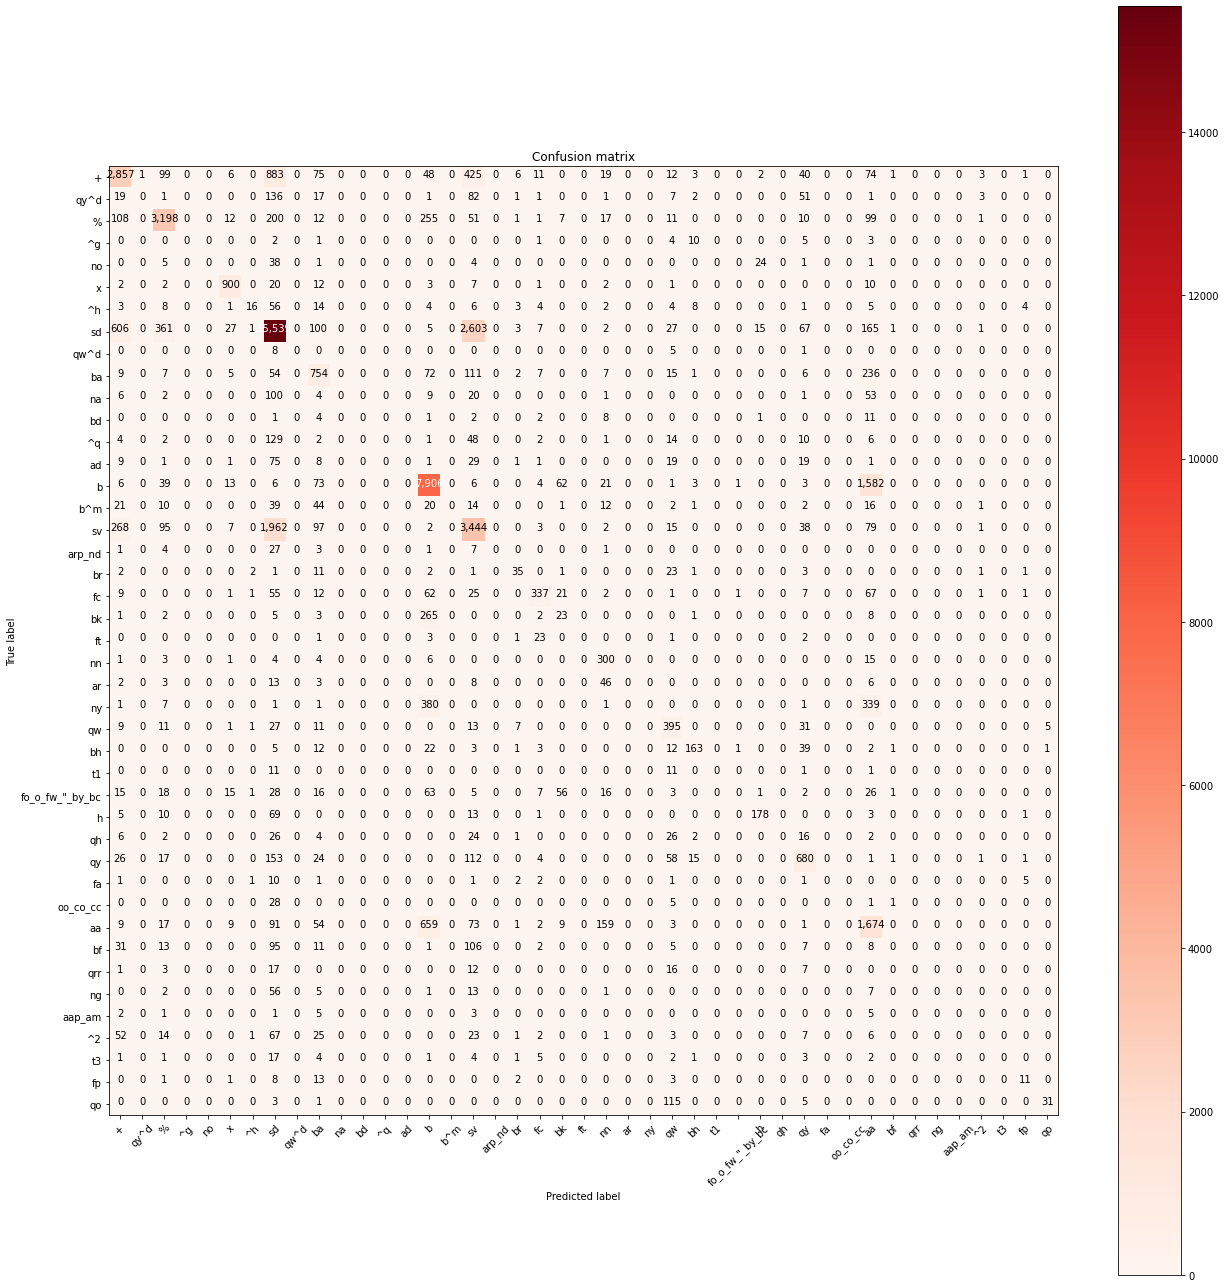

In [ ]:
cm = plot_cm(test_predictions, y_test)

In [ ]:
class_accu('br', cm)
class_accu('bf', cm)

accuracy of  br  is : 0.4166666666666667
accuracy of  bf  is : 0.0


## Minority Classes



Minority classes are frequently misidentified as majority classes, owing to the fact that majority classes have significantly more data and thus can be trained on. With 33 percent and 17 percent, respectively, the classes "sd" (40) and "b" (10) are the most common here. 




## Minority Class showcase
The frequencies of the data are plotted in the graph below. This illustrates how some classes are common, while the majority of classes are rare. 

Only 0.13 percent of the data belongs to the "br" class, while 0.42 percent belongs to the "bf" class. 

In [ ]:
# Print the frequency of the "br" and "bf" classes
value_counts = reduced_df["act_tag"].value_counts()
bf_frequency = value_counts["bf"]/sum(value_counts)
print("bf frequency: " + str(bf_frequency*100) + "%")

br_frequency = value_counts["br"]/sum(value_counts)
print("br frequency: " + str(br_frequency*100) + "%")

bf frequency: 0.42977379855638936%
br frequency: 0.13371734211067682%


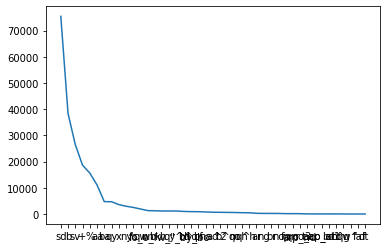

In [ ]:
# Plot the frequencies of the classes

plt.plot(value_counts)

# Model 2 - Balanced Network


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))

## Define & Train the model

In [ ]:
# Re-built the model for the balanced training
model2 = Sequential(
    [Embedding(mask_zero = False, input_dim = VOCAB_SIZE + 1, output_dim = EMBED_SIZE, input_length = MAX_LENGTH, embeddings_initializer='glorot_uniform'),
     Bidirectional(LSTM(43, return_sequences = True)),
     Bidirectional(LSTM(43, return_sequences = False)),
     Dense(HIDDEN_SIZE),
     Activation('softmax')]
)
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 100)          4373300   
                                                                 
 bidirectional_8 (Bidirectio  (None, 150, 86)          49536     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 43)                3741      
                                                                 
 activation_3 (Activation)   (None, 43)                0         
                                                                 
Total params: 4,471,297
Trainable params: 4,471,297
No

In [ ]:
history = model2.fit(train_input,
                    train_labels,
                    epochs=3,
                    batch_size=256,
                    validation_data=(val_input, val_labels),
                    class_weight = d_class_weights,
                    verbose=1)

Epoch 1/3
547/547 [==============================] - 35s 46ms/step - loss: 3.1807 - accuracy: 0.2180 - val_loss: 2.4385 - val_accuracy: 0.3634
Epoch 2/3
547/547 [==============================] - 25s 46ms/step - loss: 2.4233 - accuracy: 0.3685 - val_loss: 2.2188 - val_accuracy: 0.4026
Epoch 3/3
547/547 [==============================] - 26s 47ms/step - loss: 2.0011 - accuracy: 0.3966 - val_loss: 2.2464 - val_accuracy: 0.3486


## Test the model

In [ ]:
# Overall Accuracy
score = model2.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 9s 16ms/step - loss: 2.2841 - accuracy: 0.3247


In [ ]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 32.47111141681671


In [ ]:
test_predictions_2 = np.argmax(model2.predict(test_sentences_X, batch_size = 100), axis=1)

In [ ]:
test_predictions_2

array([16, 14, 30, ..., 19, 20, 32])

## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

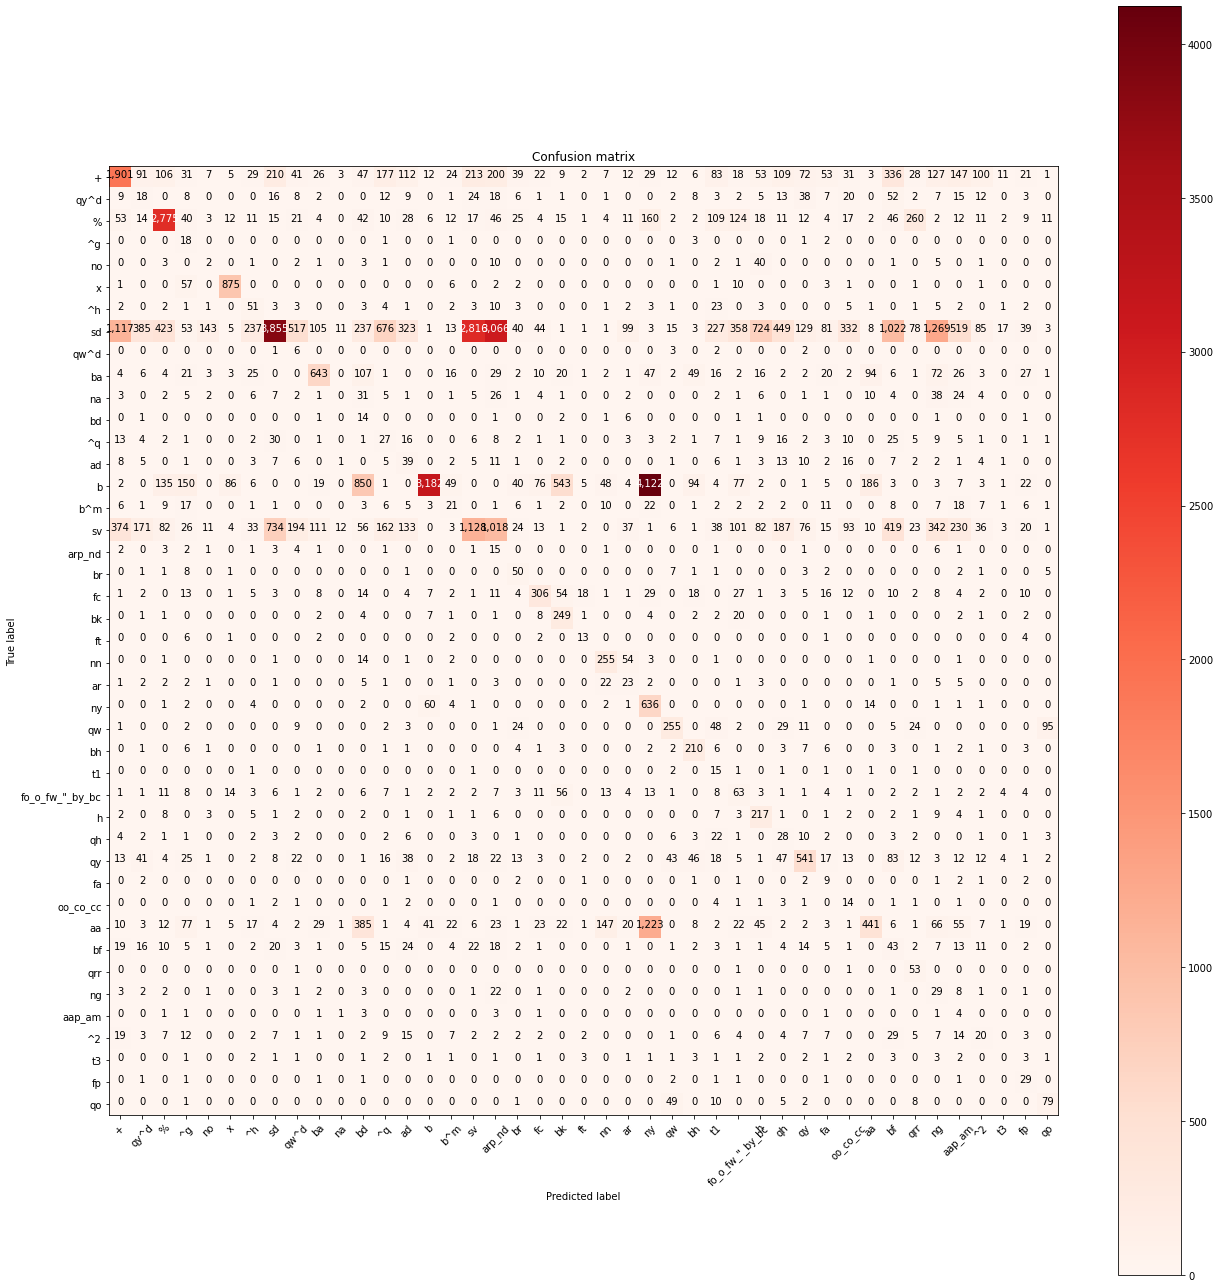

In [ ]:
cm_2 = plot_cm(test_predictions_2, y_test)

In [ ]:
class_accu('br', cm_2)
class_accu('bf', cm_2)

accuracy of  br  is : 0.5952380952380952
accuracy of  bf  is : 0.15412186379928317






### Explanation



### Other ways to handle imbalanced classes




Explanation - <br><br>
**Here we use the same model as before but we instead pass it class weights to balance out the under represented classes. Since we assigned more weights to the minority classes, the model was able to predict more properly for these classes. We see that the accuracy for bf and br has increased slightly but the overall accuracy has decreased significantly.**
<br><br><br>
Other ways to handle imbalanced classes - 
<br><br>
1. **Undersampling - Taking only a part of points from the majority classes**
2. **Oversampling - Replicating some points from the minority class to increase its cardinality**
3. **Generating synthetic data - Creating more data for the minority classes to increase their size manually.**

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

# Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each utterance for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current utterance. 

To make it easier to train, we combined all of the utterances into one long sequence rather than breaking them up into individual dialogues.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output


## CNN


This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes.

In [ ]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Input,LSTM
from tensorflow.keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization,MaxPool2D,Concatenate, Flatten


filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors)+1
MAX_LENGTH = 150
EMBED_SIZE = 100 
HIDDEN_SIZE = len(unique_tags) 

inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

c1 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
b1 = BatchNormalization()(c1)
c2 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
b2 = BatchNormalization()(c2)
c3 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
b3 = BatchNormalization()(c3)

m1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(b1)
m2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(b2)
m3 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(b3)

In [ ]:
concat_ms = concatenate([m1, m2, m3])
# flatten concatenated tensors
flattened_ms = TimeDistributed(Flatten())(concat_ms)
# dense layer (dense_1)
d1 = Dense(EMBED_SIZE, activation='relu')(flattened_ms)
# dropout_1
dropout_1 = Dropout(drop)(d1)

## BLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM.
    

In [ ]:
bd1=Bidirectional(LSTM(EMBED_SIZE,return_sequences=True))(dropout_1)
bd2=Bidirectional(LSTM(EMBED_SIZE,return_sequences=False))(bd1)
d2=Dense(EMBED_SIZE, activation='softmax')(bd2)
flattened_layer = Flatten()(dropout_1)
dropout_2 = Dropout(drop)(d2)

Concatenate 2 last layers and create the output layer
network

In [ ]:
a=concatenate([flattened_layer,dropout_2])
dense_layer = Dense(43, activation = 'softmax')(a)
model3 = Model(inputs=inputs, outputs=dense_layer)
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 150, 100)     4373200     ['input_3[0][0]']                
                                                                                                  
 reshape_2 (Reshape)            (None, 150, 100, 1)  0           ['embedding_6[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)              (None, 148, 1, 64)   19264       ['reshape_2[0][0]']              
                                                                                            

Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.
layer

In [ ]:
# Train the model - use validation 
model3.fit(train_input,
                     train_labels,
                     epochs=3,
                     batch_size=100,
                     validation_data=(val_input, val_labels),verbose=1)

Epoch 1/3
1400/1400 [==============================] - 49s 30ms/step - loss: 1.1217 - accuracy: 0.6661 - val_loss: 1.0161 - val_accuracy: 0.7038
Epoch 2/3
1400/1400 [==============================] - 35s 25ms/step - loss: 0.9707 - accuracy: 0.7088 - val_loss: 1.0133 - val_accuracy: 0.7123
Epoch 3/3
1400/1400 [==============================] - 36s 26ms/step - loss: 0.9379 - accuracy: 0.7212 - val_loss: 1.0418 - val_accuracy: 0.7087


In [ ]:
score = model3.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 10s 18ms/step - loss: 1.0283 - accuracy: 0.7091


In [ ]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 70.9080159664154


In [ ]:
test_predictions_3 = np.argmax(model3.predict(test_sentences_X, batch_size = 100), axis=1)

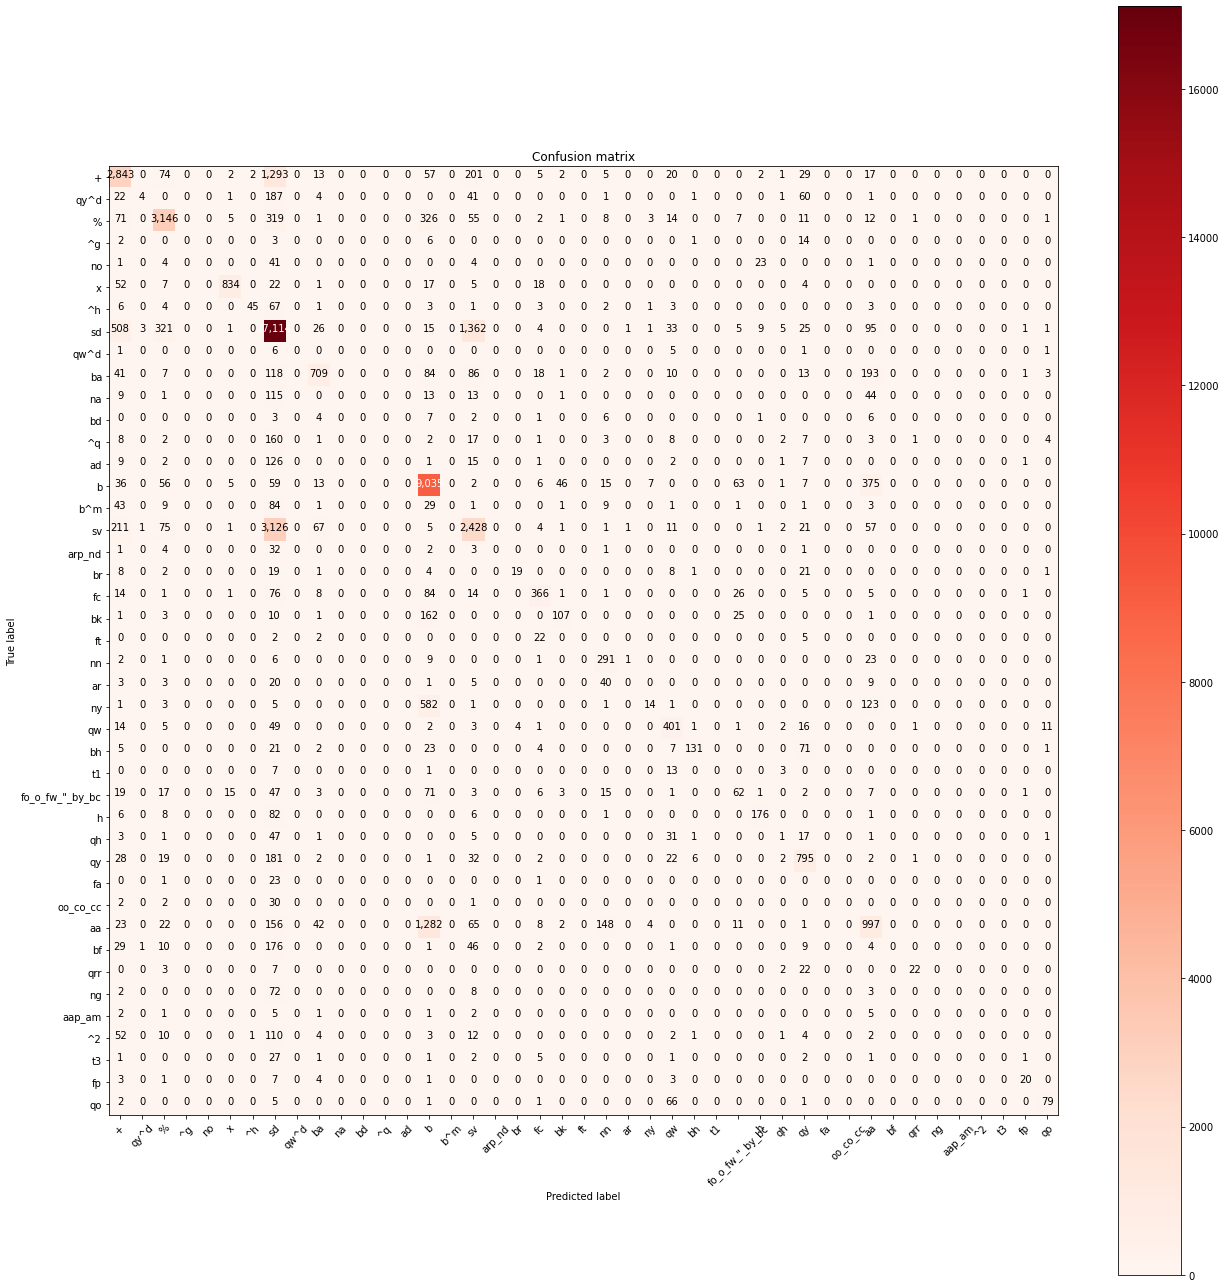

In [ ]:
cm3 = plot_cm(test_predictions_3, y_test)

In [ ]:
class_accu('br', cm3)
class_accu('bf', cm3)

accuracy of  br  is : 0.2261904761904762
accuracy of  bf  is : 0.0


In [ ]:
true_labels = np.argmax(y_test, axis=1)
true_labels

array([16, 14, 16, ..., 19, 19, 19])

In [ ]:
pos_change = []
neg_change = []

for i in range(len(y_test)):
  true_label = true_labels[i]
  model1_pred = test_predictions[i]
  model3_pred = test_predictions_3[i]
  
  if true_label == model1_pred and true_label != model3_pred:
    neg_change.append(i)
  elif true_label != model1_pred and true_label == model3_pred:
    pos_change.append(i)

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in wordvectors.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

### These are all the sentences which were wrongly predicted by model 1 but correctly predicted by model 3:

In [ ]:
for i, val in enumerate(pos_change):
  print(decode_sentence(X_test[val]))

{D Now, } {F uh, } # {D you know } if they ever, # -/
{D Wel-, }  I guess it kind of borders on  [ where, + {E I mean } what ] do you value more.  The invasion of, {F uh, } the person's privacy or the  possible danger to, {D you know, } other people. /
{D Well, } how do you feel about trial by jury? /
presently practiced. /
{D So, } do you think that, {E I mean } [ the + the ] stereotypical  bleeding heart juries --
Yeah,  /
-- agree with that.  /
-- {C and, }  {F uh, } [ when you, + when you are ]  selecting a jury and you are doing it partially [ if, + if ] not entirely on the basis of which  color representation you have --
{D Well, } let's see,  /
-- {C because } [ they don't want to know, +  they almost  don't want to know ] us. /
{F Uh, } yes,  /
{D Well, }
[ You + --
-- sometimes it's just spouse and me.  /
Sometimes that's okay. /
{D You know, } right,  /
Those are the youngest ones? /
that's where they've gone to make their homes. /
They, {F uh, } just working up there or goin